# Amortized Neural Variational Inference for a toy probabilistic model


Consider a certain number of sensors  placed at known locations, $\mathbf{s}_1,\mathbf{s}_2,\ldots,\mathbf{s}_L$. There is a target at an unknown position $\mathbf{z}\in\mathbb{R}^2$ that is emitting a certain signal that is received at the $i$-th sensor with a signal strength distributed as follows:

\begin{align}
x_i \sim \mathcal{N}\Big(- A \log\left(||\mathbf{s}_i-\mathbf{z} ||^2\right), \sigma^2\Big),
\end{align}

where $A$ is a constant related to how fast signal strength degrades with distance. We assume a Gaussian prior for the unknown position $\mathcal{N}(\mathbf{0},\mathbf{I})$. Given a set of $N$ i.i.d. samples for each sensor, $\mathbf{X}\in\mathbb{R}^{L\times N}$, we will use a Amortized Neural Variational Inference to find a Gaussian approximation to 

\begin{align}
p(\mathbf{z}|\mathbf{X}) \propto  p(\mathbf{X}|\mathbf{z}) p(\mathbf{z})
\end{align}

Our approximation to $p(\mathbf{z}|\mathbf{X})$ is of the form
\begin{align}
p(\mathbf{z}|\mathbf{X}) \approx q(\mathbf{z}|\mathbf{X})=\mathcal{N}\Big(\mu(\mathbf{X}),\Sigma(\mathbf{X})\Big),
\end{align}
where

- $\mu(\mathbf{X})$ --> Given by a Neural Network with parameter vector $\theta$ and input $\mathbf{X}$

- $\Sigma(\mathbf{X})$ --> Diagonal covariance matrix, where the log of the main diagonal is constructed by a Neural Network with parameter vector $\gamma$ and input $\mathbf{X}$

## ELBO lower-bound to $p(\mathbf{X})$

We will optimize $q(\mathbf{z}|\mathbf{X})$ w.r.t. $\theta,\gamma$ by optimizing the Evidence-Lower-Bound (ELBO):

\begin{align}
p(\mathbf{X}) &= \int p(\mathbf{X}|\mathbf{z}) p(\mathbf{z}) d\mathbf{z}\\
&\geq \int q(\mathbf{X}|\mathbf{z}) \log \left(\frac{p(\mathbf{X},\mathbf{z})}{q(\mathbf{X}|\mathbf{z})}\right)d\mathbf{z}\\
& = \mathbb{E}_{q}\left[\log  p(\mathbf{X}|\mathbf{z})\right] - D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})\triangleq \mathcal{L}(\mathbf{X},\theta,\gamma),
\end{align}
where $D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})$ is known in closed form since it is the KL divergence between two Gaussian pdfs:

\begin{align}
D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})) = \frac{1}{2} \left[\text{tr}\left(\Sigma(\mathbf{X})\right)+\left(\mu(\mathbf{X})^T\mu(\mathbf{X})\right)-2-\log\det \left(\Sigma(\mathbf{X})\right) \right]
\end{align}

## SGD optimization

- Sample $\mathbf{\epsilon}\sim \mathcal{N}(\mathbf{0},\mathbf{I})$
- Sample from $q(\mathbf{z}|\mathbf{X})$:
\begin{align}
\mathbf{z}^0 = \mu(\mathbf{X}) + \sqrt{\text{diag}(\Sigma(\mathbf{X}))} \circ \mathbf{\epsilon}
\end{align}
- Compute gradients of 
\begin{align}
\hat{\mathcal{L}}(\mathbf{X},\theta,\gamma) =\log  p(\mathbf{X}|\mathbf{z}^0) - D_{KL}(q(\mathbf{z}|\mathbf{X})||p(\mathbf{z})
\end{align}
w.r.t. $\theta,\gamma$




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline

# use seaborn plotting defaults
import seaborn as sns; sns.set()

/Users/olmos/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Probabilistic model definition and generating samples

In [2]:
############## Elements of the true probabilistic model ####################

loc_info = {}                           
        
loc_info['S'] = 3 # Number o sensors

loc_info['pos_s'] = np.array([[0.5,1], [3.5,1], [2,3]]) #Position of sensors

#loc_info['target'] = np.random.uniform(-3,3,[2,])  #(Unknown target position)

loc_info['target'] = np.array([-1,2])  #(Unknown target position)

loc_info['var_s'] = 5.*np.ones(loc_info['S']).reshape([loc_info['S'],1]) #Variance of sensors

loc_info['A'] = np.ones(loc_info['S'],dtype=np.float32) * 10.0 #Attenuation mean factor per sensor

loc_info['N'] = 5 # Number of measurements per sensor

def sample_X(S,M,z,pos_s,A,var_s):
    
    means = -1*A*np.log(np.sum((pos_s-z)**2,1))
    
    X = means.reshape([S,1]) + np.random.randn(S,M) * np.sqrt(var_s)
    
    return X


In [3]:
# Sampling from model for the right target
    
X = sample_X(loc_info['S'],loc_info['N'], loc_info['target'],loc_info['pos_s'],loc_info['A'],loc_info['var_s'])

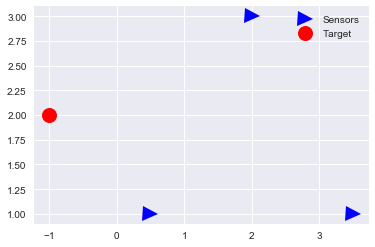

In [4]:
plt.plot(loc_info['pos_s'][:,0],loc_info['pos_s'][:,1],'b>',label='Sensors',ms=15)
plt.plot(loc_info['target'][0],loc_info['target'][1],'ro',label='Target',ms=15)
plt.legend()

### TensorFlow Computation Graph and Loss Function

In [5]:
z_dim = 2       #Latent Space

model_name = 'model1'   #In 'model1.py' we define the variational family

learning_rate = 1e-2
num_samples_avg = 1     #Number of samples to approximate the expectation in the ELBO
num_samples = 10        #Number of samples from the posterior (for testing)
num_it = int(1e4)       #SGD iterations
period_plot = int(1000) #Show resuts every period_plot iterations
dims = X.shape #X.shape


In [6]:
sess_VAE = tf.Graph()

with sess_VAE.as_default():
    
    print('[*] Importing model: ' + model_name)
    model = __import__(model_name)
    
    print('[*] Defining placeholders')

    inputX = tf.placeholder(tf.float32, shape=dims, name='x-input')
    
    print('[*] Defining the encoder')
    log_var, mean, samples_z, KL = model.encoder(inputX,dims,z_dim,num_samples_avg)
        
    print('[*] Defining the log_likelyhood')
    
    loglik = model.decoder(loc_info,inputX,samples_z,num_samples_avg)  
        
    loss = -(loglik-KL)
    
    optim = tf.train.AdamOptimizer(learning_rate).minimize(loss)
    
    # Output dictionary -> Useful if computation graph is defined in a separate .py file
    
    tf_nodes = {}
    
    tf_nodes['X'] = inputX
    
    tf_nodes['mean'] = mean
    
    tf_nodes['logvar'] = log_var

    tf_nodes['KL'] = KL
    
    tf_nodes['loglik'] = loglik
    
    tf_nodes['optim'] = optim
    
    tf_nodes['samples'] = samples_z
    

[*] Importing model: model1
[*] Defining placeholders
[*] Defining the encoder
[*] Defining the log_likelyhood


## SGD optimization

In [7]:
   
############ SGD Inference #####################################

mean_list = []
    
with tf.Session(graph=sess_VAE) as session:
    
    # Add ops to save and restore all the variables.
    saver = tf.train.Saver()

    tf.global_variables_initializer().run()
        
    print('Training the VAE ...')    
    
    for it in range(num_it):

        feedDict = {tf_nodes['X'] : X}  

        _= session.run(tf_nodes['optim'],feedDict)

        
        if(it % period_plot ==0):
            
            mean, logvar,loglik,KL = session.run([tf_nodes['mean'],tf_nodes['logvar'],tf_nodes['loglik'],tf_nodes['KL']],feedDict)

            print("It = %d, loglik = %.5f, KL = %.5f" %(it,loglik,KL))

            mean_list.append(mean)

        
    samples = session.run(tf_nodes['samples'],feedDict)


Training the VAE ...
It = 0, loglik = -50926.40625, KL = 1.63167
It = 1000, loglik = -113.08937, KL = 7.00147
It = 2000, loglik = -115.41471, KL = 7.60987
It = 3000, loglik = -115.16046, KL = 7.83914
It = 4000, loglik = -112.18390, KL = 8.10726
It = 5000, loglik = -113.60258, KL = 8.09174
It = 6000, loglik = -134.30858, KL = 8.19208
It = 7000, loglik = -113.80139, KL = 8.34016
It = 8000, loglik = -323.55902, KL = 7.21795
It = 9000, loglik = -118.62814, KL = 8.40690


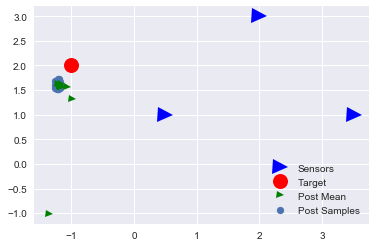

In [8]:
#Samples from q(z|x)
m_evol = np.vstack(mean_list)
nsamples = 50

samples = mean + np.sqrt(np.exp(logvar)) * np.random.randn(nsamples,2)

plt.plot(loc_info['pos_s'][:,0],loc_info['pos_s'][:,1],'b>',label='Sensors',ms=15)
plt.plot(loc_info['target'][0],loc_info['target'][1],'ro',label='Target',ms=15)
plt.plot(m_evol[:,0],m_evol[:,1],'g>',label='Post Mean')
plt.scatter(samples[:,0],samples[:,1],label='Post Samples')
plt.rcParams["figure.figsize"] = [8,8]
plt.legend()